In [2]:
import os
from matplotlib.image import imread
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3, VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = '/kaggle/input/flowers-recognition/flowers'
os.listdir(data)

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [4]:
# List label directories
labels = os.listdir(data)
print("Labels:", labels)

Labels: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


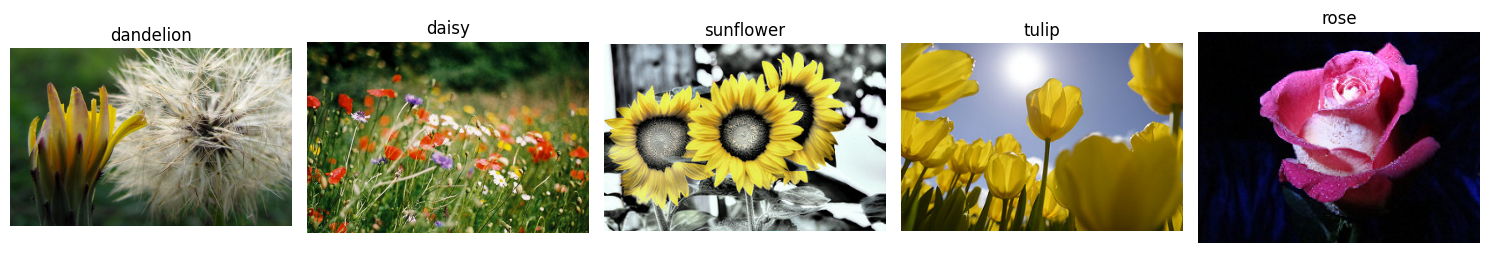

In [5]:
# Display a few images from each label
import random
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))  # Display 5 images
for i, label_name in enumerate(labels):
    if i >= 5:  # Limit to 5 images for simplicity
        break
    label_path = os.path.join(data, label_name)
    img_name = random.choice(os.listdir(label_path))  # Pick the first image
    img_path = os.path.join(label_path, img_name)
    
    img = imread(img_path)  # Load the image
    axes[i].imshow(img)
    axes[i].set_title(label_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Load the image
image = imread(img_path)

In [7]:
image.shape

(180, 240, 3)

In [8]:
image.max()

255

In [9]:
image.min()

0

In [28]:
# Define data augmentation for training (already done)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 👈 Splitting dataset (80% train, 20% validation)
)

# Load training data
train_data = datagen.flow_from_directory(
    data,  # Path to dataset
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'  # 👈 80% of data for training
)

# Create a separate ImageDataGenerator for validation (NO augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load validation data
val_data = val_datagen.flow_from_directory(
    data,  # Path to dataset
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle = False                 # 👈 20% of data for validation
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


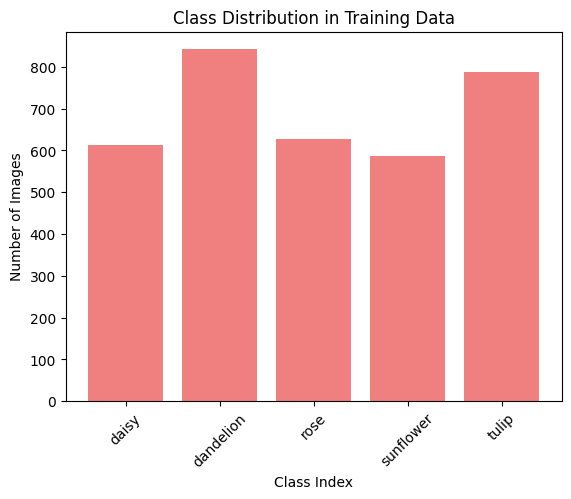

In [11]:
# Assuming train_data is created using ImageDataGenerator.flow_from_directory
print(train_data.class_indices)  # Shows class-to-index mapping

# Get class counts from the generator
class_counts = train_data.classes
unique, counts = np.unique(class_counts, return_counts=True)

# Plot the distribution
plt.bar(unique, counts, color='lightcoral')
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.xticks(unique, labels=train_data.class_indices.keys(), rotation=45)
plt.show()


## CNN model

In [23]:
# Define image size and number of classes

cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.25))

cnn_model.add(Dense(5, activation='softmax')) 

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 150, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 150, 150, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150, 150, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150, 150, 32)        │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 720000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │       3,600,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,548,049 (59.31 MB)

 Trainable params: 5,182,661 (19.77 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 10,365,324 (39.54 MB)

In [24]:
early_stop = EarlyStopping(monitor='accuracy', patience=8)

results = model.fit(train_data, epochs=50,
                    validation_data=val_data,
                    callbacks=[early_stop])

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2391 - loss: 1.5988 - val_accuracy: 0.2442 - val_loss: 1.5989
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2674 - loss: 1.5919 - val_accuracy: 0.2442 - val_loss: 1.5987
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2446 - loss: 1.5996 - val_accuracy: 0.2442 - val_loss: 1.5988
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2304 - loss: 1.6020 - val_accuracy: 0.2442 - val_loss: 1.5987
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2389 - loss: 1.6018 - val_accuracy: 0.2442 - val_loss: 1.5986
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2595 - loss: 1.5955 - val_accuracy: 0.2442 - val_loss: 1.5985
Epoch 7/50


KeyboardInterrupt: 

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
model.evaluate(val_data)

In [45]:
from tensorflow.keras.applications import EfficientNetB3
# Create Model Structure
img_size = (224, 224)
channels = 3

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential()
model.add(base_model)  # Add EfficientNetB3
model.add(GlobalAveragePooling2D())  # Add pooling layer
model.add(Dense(128, activation='relu'))  # Fully connected layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,980,916 (41.89 MB)

 Trainable params: 197,381 (771.02 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
early_stop = EarlyStopping(monitor='accuracy', patience=5)
results = model.fit(train_data, epochs=50,
                    validation_data=val_data,
                    callbacks=[early_stop])

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.2181 - loss: 1.6377 - val_accuracy: 0.2419 - val_loss: 1.6007
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 716ms/step - accuracy: 0.2454 - loss: 1.6063 - val_accuracy: 0.2279 - val_loss: 1.6048
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 710ms/step - accuracy: 0.2263 - loss: 1.6086 - val_accuracy: 0.2442 - val_loss: 1.6062
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 728ms/step - accuracy: 0.2364 - loss: 1.6086 - val_accuracy: 0.2442 - val_loss: 1.6044
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 716ms/step - accuracy: 0.2413 - loss: 1.6032 - val_accuracy: 0.2279 - val_loss: 1.5976
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 704ms/step - accuracy: 0.2483 - loss: 1.6017 - val_accuracy: 0.2442 - val_loss: 1.5986
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 716ms/step - accuracy: 0.2296 - loss: 1.6005 - val_accuracy: 0.2442 - val_loss: 1.5971
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 719ms/step - accuracy: 0.2509 - loss: 1.5998 - val_accurac

## resnet_model

In [39]:
from tensorflow.keras.applications import ResNet50
# Initialize the ResNet model
resnet_model = Sequential()

# Load the pretrained ResNet50 model without the top classification layers
pretrained_model = ResNet50(include_top=False,  # Exclude fully connected layers
                            input_shape=(224, 224, 3),
                            pooling='avg',  # Global average pooling
                            weights="imagenet")  # Use ImageNet pre-trained weights

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained ResNet model
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(BatchNormalization())

resnet_model.add(Dense(5, activation='softmax'))

# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

# Model summary
resnet_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,815,493 (94.66 MB)

 Trainable params: 1,225,797 (4.68 MB)

 Non-trainable params: 23,589,696 (89.99 MB)

In [19]:
from tensorflow.keras.applications import ResNet50
# Initialize the ResNet model
resnet_model = Sequential()

# Load the pretrained ResNet50 model without the top classification layers
pretrained_model = ResNet50(include_top=False,  # Exclude fully connected layers
                            input_shape=(150, 150, 3),
                            pooling='avg',  # Global average pooling
                            weights="imagenet")  # Use ImageNet pre-trained weights

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained ResNet model
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())

# Add custom classification layers
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

# Add custom classification layers
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

# Add custom classification layers
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))

resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(BatchNormalization())

# Output layer (5 classes for classification)
resnet_model.add(Dense(5, activation='softmax'))

# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

# Model summary
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,865,797 (91.04 MB)

 Trainable params: 277,509 (1.06 MB)

 Non-trainable params: 23,588,288 (89.98 MB)

In [20]:
early_stop = EarlyStopping(monitor='accuracy', patience=5)
results = resnet_model.fit(train_data, epochs=50,
                    validation_data=val_data,
                    callbacks=[early_stop])


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 566ms/step - accuracy: 0.2380 - loss: 1.9441 - val_accuracy: 0.2605 - val_loss: 1.5787
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.3071 - loss: 1.6963 - val_accuracy: 0.3453 - val_loss: 1.5689
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.3044 - loss: 1.6089 - val_accuracy: 0.2302 - val_loss: 1.5854
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.3525 - loss: 1.5421 - val_accuracy: 0.3477 - val_loss: 1.5290
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.3683 - loss: 1.4691 - val_accuracy: 0.2326 - val_loss: 1.5677
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.3829 - loss: 1.4546 - val_accuracy: 0.2407 - val_loss: 1.8152
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.3944 - loss: 1.4249 - val_accuracy: 0.2709 - val_loss: 1.7852
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.3837 - loss: 1.4149 - val_accu

In [ ]:
summary = pd.DataFrame(resnet_model.history.history)
summary.head()


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Calculate training scores
train_loss, train_accuracy = resnet_model.evaluate(train_data, verbose=0)

# Calculate test scores
val_loss, val_accuracy = resnet_model.evaluate(val_data, verbose=0)

print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}")

## vgg16_model

In [35]:
vgg16_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(224, 224, 3),
                   pooling='avg',
                   weights= "imagenet")
for layer in pretrained_model.layers:
        layer.trainable=False

vgg16_model.add(pretrained_model)
vgg16_model.add(Flatten())

vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Dense(64, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Dense(32, activation='relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dense(5, activation='softmax'))

# Compile Model
vgg16_model.compile(loss='categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

vgg16_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,156,037 (57.82 MB)

 Trainable params: 439,365 (1.68 MB)

 Non-trainable params: 14,716,672 (56.14 MB)

In [36]:
early_stop = EarlyStopping(monitor='accuracy', patience=5)
results = vgg16_model.fit(train_data, epochs=50,
                    validation_data=val_data,
                    callbacks=[early_stop])


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 75s 895ms/step - accuracy: 0.2954 - loss: 1.8150 - val_accuracy: 0.5349 - val_loss: 1.4781
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 726ms/step - accuracy: 0.5302 - loss: 1.2026 - val_accuracy: 0.5686 - val_loss: 1.2709
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 714ms/step - accuracy: 0.6298 - loss: 0.9766 - val_accuracy: 0.6302 - val_loss: 1.0489
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 710ms/step - accuracy: 0.6770 - loss: 0.8741 - val_accuracy: 0.6814 - val_loss: 0.8864
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 713ms/step - accuracy: 0.7149 - loss: 0.7938 - val_accuracy: 0.7360 - val_loss: 0.7535
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 707ms/step - accuracy: 0.7396 - loss: 0.7232 - val_accuracy: 0.7488 - val_loss: 0.7163
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 726ms/step - accuracy: 0.7537 - loss: 0.6829 - val_accuracy: 0.7849 - val_loss: 0.6177
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.7582 - loss: 0.6769 - val_accu

In [41]:
summary = pd.DataFrame(vgg16_model.history.history)
summary.head()


,accuracy,loss,val_accuracy,val_loss
0,0.386462,1.561293,0.534884,1.478078
1,0.561469,1.142621,0.568605,1.270907
2,0.634654,0.963679,0.630233,1.048944
3,0.686144,0.861196,0.681395,0.886362
4,0.727220,0.768850,0.736046,0.753453


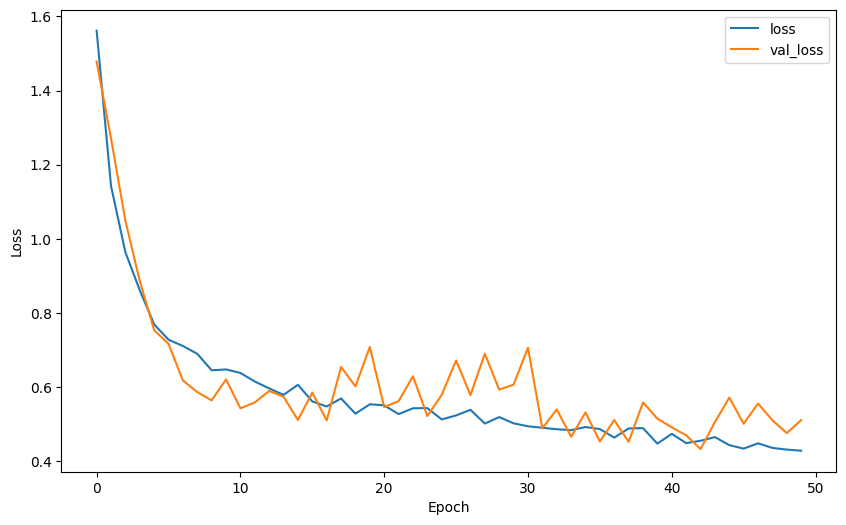

In [42]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

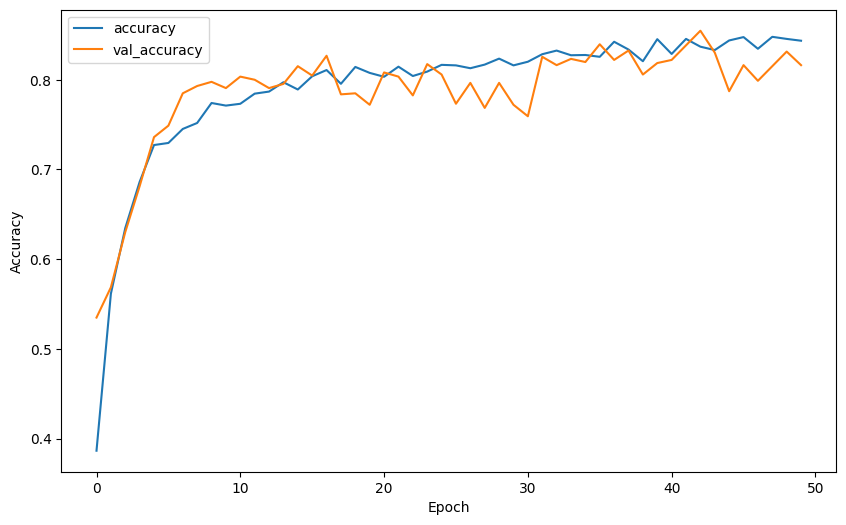

In [43]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [44]:
# Calculate training scores
train_loss, train_accuracy = vgg16_model.evaluate(train_data, verbose=0)

# Calculate test scores
val_loss, val_accuracy = vgg16_model.evaluate(val_data, verbose=0)

print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}")

Train Loss: 0.3621, Train Accuracy: 0.8626
Test Loss: 0.5106, Test Accuracy: 0.8163
